In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

In [165]:
#read train data
df = pd.read_csv('train_store1.csv')

In [166]:
df = df.drop(['MonthAbb','IfCompetition','CompetitionOpenDate'], axis=1)

In [167]:
df['Date'] = pd.to_datetime(df['Date'])
# split the last 6 weeks data as hold-out set (idea from Gert https://www.kaggle.com/c/rossmann-store-sales/discussion/18024)
df = df.sort_values(['Date'],ascending = False)
df_total = df.copy()

In [168]:
df

,Store,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,...,Month,WeekOfYear,Assortment,CompetitionDistance,StoreType_a,StoreType_b,StoreType_c,StoreType_d,IfPromo2,IsPromoMonth
511737,562,2015-12-07,20263,3202,1,0,0,1.0,0.0,0.0,...,12,50,3,1210.0,0.0,1.0,0.0,0.0,1,0
850201,934,2015-12-07,0,0,0,0,0,1.0,0.0,0.0,...,12,50,3,5460.0,1.0,0.0,0.0,0.0,1,0
123141,136,2015-12-07,0,0,0,0,0,1.0,0.0,0.0,...,12,50,3,2200.0,1.0,0.0,0.0,0.0,1,0
364285,400,2015-12-07,0,0,0,0,0,1.0,0.0,0.0,...,12,50,1,70.0,1.0,0.0,0.0,0.0,1,0
960664,1054,2015-12-07,0,0,0,0,0,1.0,0.0,0.0,...,12,50,3,13190.0,1.0,0.0,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236455,260,2013-01-01,0,0,0,0,1,0.0,1.0,0.0,...,1,1,1,540.0,1.0,0.0,0.0,0.0,1,0
907664,995,2013-01-01,0,0,0,0,1,0.0,1.0,0.0,...,1,1,1,6560.0,0.0,0.0,0.0,1.0,1,0
237397,261,2013-01-01,0,0,0,0,1,0.0,1.0,0.0,...,1,1,3,15340.0,0.0,0.0,0.0,1.0,0,1
238339,262,2013-01-01,17267,2875,1,0,1,0.0,1.0,0.0,...,1,1,1,1180.0,0.0,1.0,0.0,0.0,1,0


In [169]:
df = df.drop(['Date'], axis=1)
df_total = df_total.drop(['Date'], axis=1)

In [170]:
split_index = 6*7*1115
valid = df[:split_index] 
train = df[split_index:]

# only use data of Sales>0 and Open is 1
valid = valid[(valid.Open != 0)&(valid.Sales >0)]
train = train[(train.Open != 0)&(train.Sales >0)]
df_total = df_total[(df_total.Open != 0)&(df_total.Sales >0)]

In [171]:
# sort by index
valid.sort_index(inplace = True)
train.sort_index(inplace = True)
df_total.sort_index(inplace = True)

# split x and y
x_train, y_train = train.drop(columns = ['Sales','Customers']), np.log1p(train['Sales'])
x_valid, y_valid = valid.drop(columns = ['Sales','Customers']), np.log1p(valid['Sales'])
x_df_total, y_df_total = df_total.drop(columns = ['Sales','Customers']), np.log1p(df_total['Sales'])

In [172]:
# define eval metrics
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [174]:
# try random forest
from sklearn.linear_model import LinearRegression

clf = LinearRegression()
clf.fit(x_train, y_train)
# validation
y_pred = clf.predict(x_valid)
error = rmspe(np.expm1(y_valid), np.expm1(y_pred))
print('RMSPE: {:.4f}'.format(error))

RMSPE: 0.4289


In [176]:
from sklearn.linear_model import Lasso, Ridge
clf = Ridge(alpha=0.1)
clf.fit(x_train, y_train)
# validation
y_pred = clf.predict(x_valid)
error = rmspe(np.expm1(y_valid), np.expm1(y_pred))
print('RMSPE: {:.4f}'.format(error))


RMSPE: 0.4289


In [178]:
# try random forest
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(n_estimators = 15)
clf.fit(x_train, y_train)
# validation
y_pred = clf.predict(x_valid)
error = rmspe(np.expm1(y_valid), np.expm1(y_pred))
print('RMSPE: {:.4f}'.format(error))

RMSPE: 0.1572


Text(0.5, 1.0, 'Feature Importance')

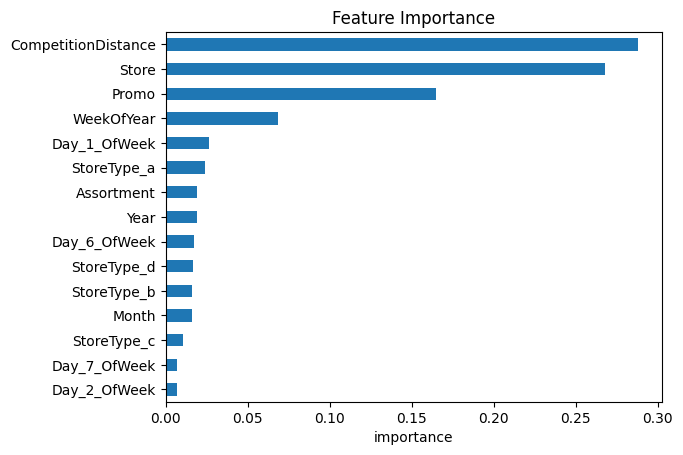

In [179]:
# plot feature importance for random forest model, show top 10 features
feat_importances = pd.Series(clf.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).sort_values(ascending = True).plot(kind='barh')
plt.xlabel('importance')
plt.title('Feature Importance')

In [120]:
import xgboost as xgb

params = {"objective": "reg:linear", # for linear regression
          "booster" : "gbtree",   # use tree based models 
          "eta": 0.03,   # learning rate
          "max_depth": 10,    # maximum depth of a tree
          "subsample": 0.9,    # Subsample ratio of the training instances
          "colsample_bytree": 0.7,   # Subsample ratio of columns when constructing each tree
          "silent": 1,   # silent mode
          "seed": 10   # Random number seed
          }
num_boost_round = 4000

dtrain = xgb.DMatrix(x_train, y_train)
dvalid = xgb.DMatrix(x_valid, y_valid)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
# train the xgboost model
model = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds= 100, feval=rmspe_xg, verbose_eval=True)

[06:56:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[06:56:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-rmse:8.02378	train-rmspe:0.99981	eval-rmse:7.96627	eval-rmspe:0.99980
[1]	train-rmse:7.78357	train-rmspe:0.99971	eval-rmse:7.72789	eval-rmspe:0.99970
[2]	train-rmse:7.55064	train-rmspe:0.99959	eval-rmse:7.49571	eval-rmspe:0.99958
[3]	train-rmse:7.32472	train-rmspe:0.99944	eval-rmse:7.27060	eval-rmspe:0.99942
[4]	train-rmse:7.10561	train-rmspe:0.99927	eval-rmse:7.05238	eval-rmspe:0.99924
[5]	train-rmse:6.89302	train-rmspe:0.99905	eval-rmse:6.84139	eval-rmspe:0.99902
[6]	train-rmse:6.68679	train-rmspe:0.99880	eval-rmse:6.63704	eval-rmspe:0.99876
[7]	train-rmse:6.48682	train-rmspe:0.99849	ev

[97]	train-rmse:0.50996	train-rmspe:0.38883	eval-rmse:0.50218	eval-rmspe:0.37338
[98]	train-rmse:0.49926	train-rmspe:0.38340	eval-rmse:0.49150	eval-rmspe:0.36736
[99]	train-rmse:0.48920	train-rmspe:0.37831	eval-rmse:0.48121	eval-rmspe:0.36150
[100]	train-rmse:0.47948	train-rmspe:0.37346	eval-rmse:0.47125	eval-rmspe:0.35586
[101]	train-rmse:0.46999	train-rmspe:0.36876	eval-rmse:0.46153	eval-rmspe:0.35038
[102]	train-rmse:0.46076	train-rmspe:0.36423	eval-rmse:0.45221	eval-rmspe:0.34514
[103]	train-rmse:0.45172	train-rmspe:0.35978	eval-rmse:0.44311	eval-rmspe:0.34002
[104]	train-rmse:0.44337	train-rmspe:0.35560	eval-rmse:0.43483	eval-rmspe:0.33537
[105]	train-rmse:0.43538	train-rmspe:0.35173	eval-rmse:0.42666	eval-rmspe:0.33081
[106]	train-rmse:0.42772	train-rmspe:0.34814	eval-rmse:0.41894	eval-rmspe:0.32653
[107]	train-rmse:0.42035	train-rmspe:0.34468	eval-rmse:0.41178	eval-rmspe:0.32259
[108]	train-rmse:0.41335	train-rmspe:0.34154	eval-rmse:0.40475	eval-rmspe:0.31877
[109]	train-rmse:0.

[197]	train-rmse:0.23685	train-rmspe:0.28450	eval-rmse:0.23571	eval-rmspe:0.25418
[198]	train-rmse:0.23652	train-rmspe:0.28440	eval-rmse:0.23564	eval-rmspe:0.25442
[199]	train-rmse:0.23543	train-rmspe:0.28354	eval-rmse:0.23461	eval-rmspe:0.25346
[200]	train-rmse:0.23476	train-rmspe:0.28310	eval-rmse:0.23404	eval-rmspe:0.25305
[201]	train-rmse:0.23427	train-rmspe:0.28029	eval-rmse:0.23362	eval-rmspe:0.25279
[202]	train-rmse:0.23405	train-rmspe:0.28032	eval-rmse:0.23344	eval-rmspe:0.25281
[203]	train-rmse:0.23377	train-rmspe:0.28023	eval-rmse:0.23319	eval-rmspe:0.25272
[204]	train-rmse:0.23291	train-rmspe:0.27877	eval-rmse:0.23237	eval-rmspe:0.25201
[205]	train-rmse:0.23270	train-rmspe:0.27878	eval-rmse:0.23221	eval-rmspe:0.25201
[206]	train-rmse:0.23243	train-rmspe:0.27869	eval-rmse:0.23236	eval-rmspe:0.25253
[207]	train-rmse:0.23181	train-rmspe:0.27811	eval-rmse:0.23166	eval-rmspe:0.25193
[208]	train-rmse:0.23162	train-rmspe:0.27813	eval-rmse:0.23151	eval-rmspe:0.25194
[209]	train-rmse

[297]	train-rmse:0.19626	train-rmspe:0.24791	eval-rmse:0.20195	eval-rmspe:0.22516
[298]	train-rmse:0.19612	train-rmspe:0.24778	eval-rmse:0.20181	eval-rmspe:0.22502
[299]	train-rmse:0.19565	train-rmspe:0.24736	eval-rmse:0.20139	eval-rmspe:0.22455
[300]	train-rmse:0.19536	train-rmspe:0.24709	eval-rmse:0.20114	eval-rmspe:0.22428
[301]	train-rmse:0.19529	train-rmspe:0.24702	eval-rmse:0.20115	eval-rmspe:0.22438
[302]	train-rmse:0.19480	train-rmspe:0.24651	eval-rmse:0.20071	eval-rmspe:0.22383
[303]	train-rmse:0.19425	train-rmspe:0.24594	eval-rmse:0.20018	eval-rmspe:0.22321
[304]	train-rmse:0.19412	train-rmspe:0.24582	eval-rmse:0.20008	eval-rmspe:0.22312
[305]	train-rmse:0.19370	train-rmspe:0.24543	eval-rmse:0.19966	eval-rmspe:0.22266
[306]	train-rmse:0.19297	train-rmspe:0.24481	eval-rmse:0.19896	eval-rmspe:0.22197
[307]	train-rmse:0.19249	train-rmspe:0.24435	eval-rmse:0.19847	eval-rmspe:0.22141
[308]	train-rmse:0.19194	train-rmspe:0.24382	eval-rmse:0.19799	eval-rmspe:0.22085
[309]	train-rmse

[397]	train-rmse:0.17212	train-rmspe:0.22445	eval-rmse:0.18268	eval-rmspe:0.20505
[398]	train-rmse:0.17159	train-rmspe:0.22395	eval-rmse:0.18221	eval-rmspe:0.20458
[399]	train-rmse:0.17156	train-rmspe:0.22391	eval-rmse:0.18220	eval-rmspe:0.20458
[400]	train-rmse:0.17136	train-rmspe:0.22369	eval-rmse:0.18206	eval-rmspe:0.20444
[401]	train-rmse:0.17109	train-rmspe:0.22344	eval-rmse:0.18182	eval-rmspe:0.20414
[402]	train-rmse:0.17095	train-rmspe:0.22332	eval-rmse:0.18172	eval-rmspe:0.20402
[403]	train-rmse:0.17079	train-rmspe:0.22315	eval-rmse:0.18158	eval-rmspe:0.20386
[404]	train-rmse:0.17062	train-rmspe:0.22300	eval-rmse:0.18148	eval-rmspe:0.20377
[405]	train-rmse:0.17053	train-rmspe:0.22291	eval-rmse:0.18143	eval-rmspe:0.20372
[406]	train-rmse:0.17031	train-rmspe:0.22268	eval-rmse:0.18125	eval-rmspe:0.20351
[407]	train-rmse:0.17022	train-rmspe:0.22261	eval-rmse:0.18124	eval-rmspe:0.20349
[408]	train-rmse:0.16981	train-rmspe:0.22224	eval-rmse:0.18088	eval-rmspe:0.20310
[409]	train-rmse

[497]	train-rmse:0.15620	train-rmspe:0.20868	eval-rmse:0.17155	eval-rmspe:0.19398
[498]	train-rmse:0.15609	train-rmspe:0.20859	eval-rmse:0.17150	eval-rmspe:0.19393
[499]	train-rmse:0.15607	train-rmspe:0.20839	eval-rmse:0.17147	eval-rmspe:0.19390
[500]	train-rmse:0.15592	train-rmspe:0.20828	eval-rmse:0.17136	eval-rmspe:0.19379
[501]	train-rmse:0.15580	train-rmspe:0.20816	eval-rmse:0.17142	eval-rmspe:0.19395
[502]	train-rmse:0.15575	train-rmspe:0.20814	eval-rmse:0.17138	eval-rmspe:0.19392
[503]	train-rmse:0.15565	train-rmspe:0.20804	eval-rmse:0.17128	eval-rmspe:0.19381
[504]	train-rmse:0.15547	train-rmspe:0.20789	eval-rmse:0.17115	eval-rmspe:0.19368
[505]	train-rmse:0.15545	train-rmspe:0.20795	eval-rmse:0.17113	eval-rmspe:0.19366
[506]	train-rmse:0.15539	train-rmspe:0.20790	eval-rmse:0.17108	eval-rmspe:0.19361
[507]	train-rmse:0.15514	train-rmspe:0.20768	eval-rmse:0.17087	eval-rmspe:0.19339
[508]	train-rmse:0.15507	train-rmspe:0.20757	eval-rmse:0.17084	eval-rmspe:0.19337
[509]	train-rmse

[597]	train-rmse:0.14422	train-rmspe:0.19737	eval-rmse:0.16383	eval-rmspe:0.18643
[598]	train-rmse:0.14421	train-rmspe:0.19735	eval-rmse:0.16382	eval-rmspe:0.18641
[599]	train-rmse:0.14411	train-rmspe:0.19727	eval-rmse:0.16374	eval-rmspe:0.18633
[600]	train-rmse:0.14393	train-rmspe:0.19709	eval-rmse:0.16361	eval-rmspe:0.18619
[601]	train-rmse:0.14387	train-rmspe:0.19704	eval-rmse:0.16356	eval-rmspe:0.18614
[602]	train-rmse:0.14370	train-rmspe:0.19689	eval-rmse:0.16345	eval-rmspe:0.18602
[603]	train-rmse:0.14354	train-rmspe:0.19676	eval-rmse:0.16332	eval-rmspe:0.18590
[604]	train-rmse:0.14346	train-rmspe:0.19669	eval-rmse:0.16327	eval-rmspe:0.18584
[605]	train-rmse:0.14331	train-rmspe:0.19657	eval-rmse:0.16315	eval-rmspe:0.18572
[606]	train-rmse:0.14314	train-rmspe:0.19642	eval-rmse:0.16301	eval-rmspe:0.18554
[607]	train-rmse:0.14302	train-rmspe:0.19633	eval-rmse:0.16291	eval-rmspe:0.18543
[608]	train-rmse:0.14291	train-rmspe:0.19625	eval-rmse:0.16282	eval-rmspe:0.18533
[609]	train-rmse

[697]	train-rmse:0.13410	train-rmspe:0.18817	eval-rmse:0.15884	eval-rmspe:0.18138
[698]	train-rmse:0.13406	train-rmspe:0.18813	eval-rmse:0.15882	eval-rmspe:0.18134
[699]	train-rmse:0.13399	train-rmspe:0.18808	eval-rmse:0.15877	eval-rmspe:0.18129
[700]	train-rmse:0.13396	train-rmspe:0.18803	eval-rmse:0.15878	eval-rmspe:0.18131
[701]	train-rmse:0.13392	train-rmspe:0.18799	eval-rmse:0.15874	eval-rmspe:0.18128
[702]	train-rmse:0.13385	train-rmspe:0.18795	eval-rmse:0.15885	eval-rmspe:0.18140
[703]	train-rmse:0.13378	train-rmspe:0.18778	eval-rmse:0.15879	eval-rmspe:0.18134
[704]	train-rmse:0.13373	train-rmspe:0.18772	eval-rmse:0.15882	eval-rmspe:0.18136
[705]	train-rmse:0.13367	train-rmspe:0.18767	eval-rmse:0.15878	eval-rmspe:0.18133
[706]	train-rmse:0.13365	train-rmspe:0.18759	eval-rmse:0.15876	eval-rmspe:0.18131
[707]	train-rmse:0.13355	train-rmspe:0.18751	eval-rmse:0.15879	eval-rmspe:0.18135
[708]	train-rmse:0.13353	train-rmspe:0.18745	eval-rmse:0.15877	eval-rmspe:0.18133
[709]	train-rmse

[797]	train-rmse:0.12699	train-rmspe:0.17980	eval-rmse:0.15485	eval-rmspe:0.17714
[798]	train-rmse:0.12697	train-rmspe:0.17977	eval-rmse:0.15486	eval-rmspe:0.17715
[799]	train-rmse:0.12692	train-rmspe:0.17972	eval-rmse:0.15482	eval-rmspe:0.17712
[800]	train-rmse:0.12688	train-rmspe:0.17968	eval-rmse:0.15480	eval-rmspe:0.17708
[801]	train-rmse:0.12684	train-rmspe:0.17965	eval-rmse:0.15476	eval-rmspe:0.17705
[802]	train-rmse:0.12675	train-rmspe:0.17957	eval-rmse:0.15470	eval-rmspe:0.17698
[803]	train-rmse:0.12673	train-rmspe:0.17939	eval-rmse:0.15469	eval-rmspe:0.17697
[804]	train-rmse:0.12669	train-rmspe:0.17935	eval-rmse:0.15466	eval-rmspe:0.17694
[805]	train-rmse:0.12660	train-rmspe:0.17928	eval-rmse:0.15459	eval-rmspe:0.17685
[806]	train-rmse:0.12651	train-rmspe:0.17921	eval-rmse:0.15454	eval-rmspe:0.17680
[807]	train-rmse:0.12644	train-rmspe:0.17916	eval-rmse:0.15449	eval-rmspe:0.17675
[808]	train-rmse:0.12635	train-rmspe:0.17908	eval-rmse:0.15442	eval-rmspe:0.17669
[809]	train-rmse

[897]	train-rmse:0.12103	train-rmspe:0.17309	eval-rmse:0.15180	eval-rmspe:0.17408
[898]	train-rmse:0.12101	train-rmspe:0.17307	eval-rmse:0.15179	eval-rmspe:0.17407
[899]	train-rmse:0.12098	train-rmspe:0.17304	eval-rmse:0.15178	eval-rmspe:0.17407
[900]	train-rmse:0.12096	train-rmspe:0.17292	eval-rmse:0.15176	eval-rmspe:0.17404
[901]	train-rmse:0.12095	train-rmspe:0.17291	eval-rmse:0.15175	eval-rmspe:0.17403
[902]	train-rmse:0.12091	train-rmspe:0.17284	eval-rmse:0.15173	eval-rmspe:0.17402
[903]	train-rmse:0.12086	train-rmspe:0.17267	eval-rmse:0.15173	eval-rmspe:0.17401
[904]	train-rmse:0.12077	train-rmspe:0.17255	eval-rmse:0.15166	eval-rmspe:0.17394
[905]	train-rmse:0.12068	train-rmspe:0.17248	eval-rmse:0.15160	eval-rmspe:0.17387
[906]	train-rmse:0.12067	train-rmspe:0.17146	eval-rmse:0.15159	eval-rmspe:0.17386
[907]	train-rmse:0.12062	train-rmspe:0.17142	eval-rmse:0.15155	eval-rmspe:0.17383
[908]	train-rmse:0.12059	train-rmspe:0.17140	eval-rmse:0.15154	eval-rmspe:0.17382
[909]	train-rmse

[997]	train-rmse:0.11667	train-rmspe:0.16319	eval-rmse:0.14942	eval-rmspe:0.17156
[998]	train-rmse:0.11664	train-rmspe:0.16317	eval-rmse:0.14941	eval-rmspe:0.17154
[999]	train-rmse:0.11662	train-rmspe:0.16312	eval-rmse:0.14940	eval-rmspe:0.17154
[1000]	train-rmse:0.11661	train-rmspe:0.16310	eval-rmse:0.14940	eval-rmspe:0.17153
[1001]	train-rmse:0.11659	train-rmspe:0.16309	eval-rmse:0.14954	eval-rmspe:0.17172
[1002]	train-rmse:0.11653	train-rmspe:0.16304	eval-rmse:0.14951	eval-rmspe:0.17169
[1003]	train-rmse:0.11650	train-rmspe:0.16301	eval-rmse:0.14949	eval-rmspe:0.17166
[1004]	train-rmse:0.11647	train-rmspe:0.16300	eval-rmse:0.14958	eval-rmspe:0.17177
[1005]	train-rmse:0.11639	train-rmspe:0.16293	eval-rmse:0.14952	eval-rmspe:0.17170
[1006]	train-rmse:0.11637	train-rmspe:0.16292	eval-rmse:0.14950	eval-rmspe:0.17168
[1007]	train-rmse:0.11634	train-rmspe:0.16289	eval-rmse:0.14949	eval-rmspe:0.17167
[1008]	train-rmse:0.11628	train-rmspe:0.16284	eval-rmse:0.14946	eval-rmspe:0.17163
[1009]	

[1096]	train-rmse:0.11307	train-rmspe:0.15777	eval-rmse:0.14925	eval-rmspe:0.17163
[1097]	train-rmse:0.11301	train-rmspe:0.15772	eval-rmse:0.14922	eval-rmspe:0.17159
[1098]	train-rmse:0.11298	train-rmspe:0.15769	eval-rmse:0.14921	eval-rmspe:0.17159
[1099]	train-rmse:0.11294	train-rmspe:0.15766	eval-rmse:0.14918	eval-rmspe:0.17157
[1100]	train-rmse:0.11288	train-rmspe:0.15760	eval-rmse:0.14915	eval-rmspe:0.17153
[1101]	train-rmse:0.11282	train-rmspe:0.15767	eval-rmse:0.14911	eval-rmspe:0.17150
[1102]	train-rmse:0.11280	train-rmspe:0.15774	eval-rmse:0.14909	eval-rmspe:0.17148
[1103]	train-rmse:0.11279	train-rmspe:0.15771	eval-rmse:0.14909	eval-rmspe:0.17148
[1104]	train-rmse:0.11275	train-rmspe:0.15769	eval-rmse:0.14907	eval-rmspe:0.17146
[1105]	train-rmse:0.11271	train-rmspe:0.15765	eval-rmse:0.14904	eval-rmspe:0.17142
[1106]	train-rmse:0.11267	train-rmspe:0.15762	eval-rmse:0.14901	eval-rmspe:0.17139
[1107]	train-rmse:0.11264	train-rmspe:0.15759	eval-rmse:0.14899	eval-rmspe:0.17137
[110

In [121]:
# validation
y_pred = model.predict(xgb.DMatrix(x_valid))
error = rmspe(np.expm1(y_valid), np.expm1(y_pred))
print('RMSPE: {:.4f}'.format(error))

RMSPE: 0.1713


Best weight is 0.99, RMSPE is 0.1589


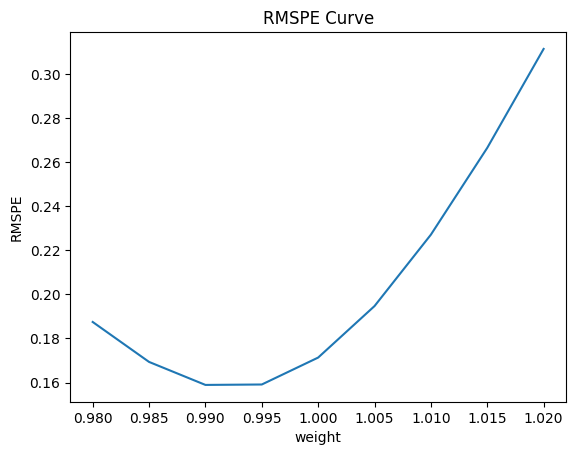

In [122]:
# rmspe correction on the whole
def correction():
    weights = np.arange(0.98, 1.02, 0.005)
    errors = []
    for w in weights:
        error = rmspe(np.expm1(y_valid), np.expm1(y_pred*w))
        errors.append(error)
        
    # make line plot
    plt.plot(weights, errors)
    plt.xlabel('weight')
    plt.ylabel('RMSPE')
    plt.title('RMSPE Curve')
    # print min error
    idx = errors.index(min(errors))
    print('Best weight is {}, RMSPE is {:.4f}'.format(weights[idx], min(errors)))
    
correction()

In [55]:
x_df_total.head().append(x_df_total.tail())

,Store,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,Day_1_OfWeek,Day_2_OfWeek,...,Assortment,CompetitionDistance,StoreType_a,StoreType_b,StoreType_c,StoreType_d,CompetitionOpenDate,IfCompetition,IfPromo2,IsPromoMonth
0,1,1,1,1,1.0,0.0,0.0,0.0,0.0,0.0,...,1,1270.0,0.0,0.0,1.0,0.0,2524,1,1,0
1,1,1,1,1,1.0,0.0,0.0,0.0,0.0,0.0,...,1,1270.0,0.0,0.0,1.0,0.0,2523,1,1,0
2,1,1,1,1,1.0,0.0,0.0,0.0,0.0,0.0,...,1,1270.0,0.0,0.0,1.0,0.0,2522,1,1,0
3,1,1,1,1,1.0,0.0,0.0,0.0,0.0,1.0,...,1,1270.0,0.0,0.0,1.0,0.0,2521,1,1,0
4,1,1,1,1,1.0,0.0,0.0,0.0,1.0,0.0,...,1,1270.0,0.0,0.0,1.0,0.0,2520,1,1,0
1017202,1115,1,1,1,1.0,0.0,0.0,0.0,1.0,0.0,...,3,5350.0,0.0,0.0,0.0,1.0,181,1,1,0
1017204,1115,1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,...,3,5350.0,0.0,0.0,0.0,1.0,120,1,1,0
1017205,1115,1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,...,3,5350.0,0.0,0.0,0.0,1.0,90,1,1,0
1017206,1115,1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,...,3,5350.0,0.0,0.0,0.0,1.0,59,1,0,1
1017207,1115,1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,...,3,5350.0,0.0,0.0,0.0,1.0,31,1,0,0


In [56]:
print(x_df_total.shape)
print(y_df_total.shape)

(844338, 28)
(844338,)
